In [14]:
# import modules
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import captum.attr

In [15]:
!python --version
torch.__version__, captum.__version__

Python 3.11.4


('2.0.1', '0.6.0')

In [16]:
# project directory
if sys.platform == 'darwin':
    home_dir = '/Users'
    MAC0_OR_LINUX1 = 0
else:
    home_dir = '/home'
    MAC0_OR_LINUX1 = 1
proj_dir = home_dir + '/dlee/im-torch/'

In [17]:
# directory
train_dir = proj_dir + 'archive/' + '7_23-06-26-loc3-nm_STACKCNN2L_2023-08-24_22-55-48/'
train_json_name = 'config_7_23-06-26-loc3-nm_STACKCNN2L_2023-08-24_22-55-48.json'
train_pt_name = '7_23-06-26-loc3-nm_E013_0.073_2023-08-24_23-00-30.pt'

In [18]:
# load config.json
with open(train_dir + train_json_name, 'r') as js:
    p = json.load(js)
p.keys()

dict_keys(['_MAC0_OR_LINUX1', '_X_te_shape', '_X_tr_shape', '_best_accuracy', '_cc_te_list', '_cc_tr_list', '_end_time', '_h5file_dir+name', '_idx_select', '_loss_fn', '_loss_tr_list', '_model', '_n_roi', '_note', '_num_batches', '_num_cells', '_optimizer', '_proj_dir', '_ptfile_name', '_save_dir', '_scheduler', '_start_time', '_tbins_te_first_10', '_tbins_tr_first_10', '_te_cc_val', '_torch_DEVICE', '_y_te_shape', '_y_tr_shape', 'batch_size', 'h5file', 'learning_rate', 'loss_fn', 'model', 'num_cells', 'num_epochs', 'num_frame_window', 'num_gpu', 'select_manual', 'select_mode', 'tbins_train_key', 'test_cc_key', 'test_resp_key', 'test_stim_key', 'test_tbins_key', 'train_resp_key', 'train_stim_key'])

In [384]:
# device 
if MAC0_OR_LINUX1:
    num_gpu = p['num_gpu']
    DEVICE = torch.device('cuda:' + str(num_gpu) if torch.cuda.is_available() else 'cpu')
else:
    DEVICE = torch.device('mps' if torch.has_mps else 'cpu')
    #!export PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

In [20]:
# load model
sys.path.append(train_dir)
from models import *

In [21]:
model = vars()[p['model']](out=p['_num_cells'])
model.load_state_dict(torch.load(train_dir + train_pt_name))
#model.eval().to(DEVICE)
model.eval()
model

STACKCNN2L(
  (conv11): Conv2d(40, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv12): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), groups=8)
  (conv13): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), groups=8)
  (conv14): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), groups=8)
  (nonlinear1): Softplus(beta=1, threshold=20)
  (conv2): Conv2d(8, 283, kernel_size=(16, 16), stride=(1, 1))
  (nonlinear2): Softplus(beta=1, threshold=20)
)

In [385]:
next(model.parameters()).device

device(type='cpu')

In [23]:
for param in model.state_dict().keys():
    print(param, '\t', model.state_dict()[param].size())

conv11.weight 	 torch.Size([8, 40, 5, 5])
conv11.bias 	 torch.Size([8])
conv12.weight 	 torch.Size([8, 1, 5, 5])
conv12.bias 	 torch.Size([8])
conv13.weight 	 torch.Size([8, 1, 5, 5])
conv13.bias 	 torch.Size([8])
conv14.weight 	 torch.Size([8, 1, 5, 5])
conv14.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([283, 8, 16, 16])
conv2.bias 	 torch.Size([283])


In [24]:
#c2 = model.state_dict()['conv2.weight'].detach().cpu().numpy()
#c2.shape

In [218]:
torch.manual_seed(0)
np.random.seed(0)
input = torch.Tensor(2*(torch.rand(20, 40, 32, 32) - 0.5))
baseline = torch.Tensor(torch.rand(20, 40, 32, 32))          #####################

In [368]:
ig = captum.attr.IntegratedGradients(model)
attr = ig.attribute(input, baseline, target=255)             #####################

In [369]:
attr.shape

torch.Size([20, 40, 32, 32])

In [370]:
attr.min()

tensor(-0.0057, dtype=torch.float64)

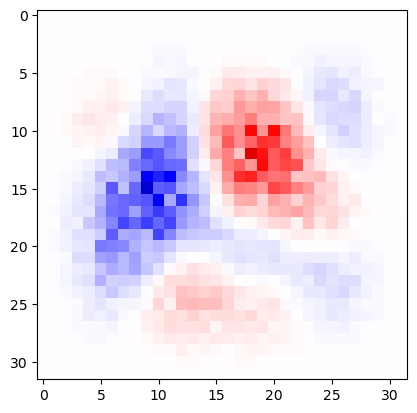

In [379]:
plt.imshow(torch.mean(attr,0)[4], cmap='seismic', vmin=-0.001, vmax=0.001)

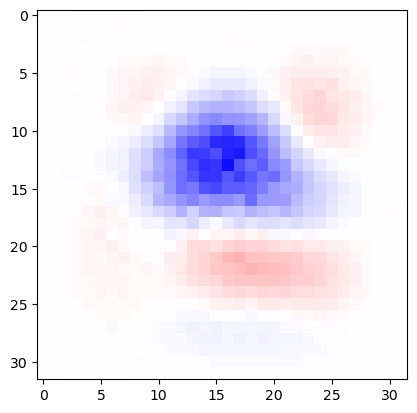

In [373]:
plt.imshow(torch.mean(attr,(0, 1)), cmap='seismic', vmin=-0.001, vmax=0.001)

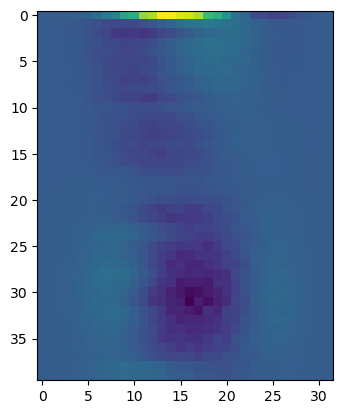

In [381]:
plt.imshow(torch.mean(torch.mean(attr,0), 1)[:, :])

In [232]:
ig.attribute?

Signature:
ig.attribute(
    inputs: ~TensorOrTupleOfTensorsGeneric,
    baselines: Union[NoneType, torch.Tensor, int, float, Tuple[Union[torch.Tensor, int, float], ...]] = None,
    target: Union[NoneType, int, Tuple[int, ...], torch.Tensor, List[Tuple[int, ...]], List[int]] = None,
    additional_forward_args: Any = None,
    n_steps: int = 50,
    method: str = 'gausslegendre',
    internal_batch_size: Optional[int] = None,
    return_convergence_delta: bool = False,
) -> Union[~TensorOrTupleOfTensorsGeneric, Tuple[~TensorOrTupleOfTensorsGeneric, torch.Tensor]]
Docstring:
This method attributes the output of the model with given target index
(in case it is provided, otherwise it assumes that output is a
scalar) to the inputs of the model using the approach described above.

In addition to that it also returns, if `return_convergence_delta` is
set to True, integral approximation delta based on the completeness
property of integrated gradients.

Args:

    inputs (Tensor or tuple[Tens